In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import os

In [2]:
datetime.datetime.now().strftime("%Y-%m-%d_%H:%M")

'2018-08-12_15:07'

In [3]:
from layers import conv_layer, max_pool_2x2, full_layer

MINIBATCH_SIZE = 100
STEPS = 1000

home = os.getcwd().split('AUT-CNN-TUB')[0]
test_path  = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_canon_28/test/')
train_path = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_canon_28/train/')

labels = ['01.0', '02.0', '03.0', '04.0', '05.0', '06.0', '07.1', '07.2',
         '08.0', '09.0','10.0','11.0', '12.0','13.0','14.0', '15.0']
position_dict = {k: v for v, k in enumerate(labels)}
label_dict = {v : k  for v, k in enumerate(labels)}

def label_to_binary(position_dict, label):
    z = np.zeros(len(position_dict), dtype=int)
    z[position_dict[label]] = 1 
    return z

def next_batch(path, size, GRBtoGray=False, flatten=False):
    
    data_path = os.path.join(path, '*g')  # ???
    files = glob.glob(data_path)
    num_imag = len(files)
    Data = np.arange(0, num_imag)
    batchindices = np.random.choice(Data, size=size,
                                    replace=False)  # Zufallsstichprobe; reihenfolge beliebig; ohne zurückl.

    label_list =[]
    img_list = []
    for i, file_path in enumerate(files):
        if i in batchindices:
            label_str = file_path.split('/')[-1][:4]
            label_bin = label_to_binary(position_dict, label_str)

            if GRBtoGray == True:
                img = cv2.imread(file_path, flags=0)
            else:
                img = cv2.imread(file_path, flags=1)

            if flatten == True:
                img_list.append(img.flatten())
                label_list.append(label_bin)
            else:
                img_list.append(img)
                label_list.append(label_bin)

    img_list = np.array(img_list)
    label_list = np.array(label_list)


    return img_list, label_list




class DataGetter:
    def __init__(self, path, GRBtoGray=False, flatten=False): 
        self.path  = path
        self.GRBtoGray  = GRBtoGray
        self.flatten  = flatten
        self.batchindices = None
        
        self.data_path = os.path.join(self.path, '*g') 
        self.files = glob.glob(self.data_path)
        self.num_imag = len(self.files)
        self.Data = list(range(0, self.num_imag))

    def get_batch(self,size):
        
        if len(self.Data) > size:
            self.batchindices = list(np.random.choice(self.Data, size=size, replace=False))
            for x in self.batchindices:
                self.Data.remove(x) 
                
        elif len(self.Data) == size:
            self.batchindices = np.random.choice(self.Data, size=size, replace=False)  
            self.Data = list(range(0, self.num_imag))

            
        else:
            self.batchindices = np.random.choice(self.Data, size=len(self.Data), replace=False)  
            self.Data = list(range(0, self.num_imag))



            

        label_list =[]
        img_list = []
        file_name_list = []
        for i, file_path in enumerate(self.files):
            if i in self.batchindices:
                label_str = file_path.split('/')[-1][:4]
                label_bin = label_to_binary(position_dict, label_str)

                if self.GRBtoGray == True:
                    img = cv2.imread(file_path, flags=0)
                else:
                    img = cv2.imread(file_path, flags=1)

                if self.flatten == True:
                    img_list.append(img.flatten())
                    label_list.append(label_bin)
                    file_name_list.append(file_path.split('/')[-1])
                else:
                    img_list.append(img)
                    label_list.append(label_bin)
                    file_name_list.append(file_path.split('/')[-1])

        img_list = np.array(img_list)
        label_list = np.array(label_list)


        return img_list, label_list, file_name_list
    
test_img = DataGetter(test_path, False, False)
train_img = DataGetter(train_path, False, False)


In [4]:
try:
    print('closing session')
    sess.close()

except:
    None

#mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)

x = tf.placeholder(tf.float32, shape=[None, 28, 28, 3])
y_ = tf.placeholder(tf.float32, shape=[None, len(position_dict)])

#x_image = tf.reshape(x, [-1, 28, 28, 1])
conv1 = conv_layer(x, shape=[5, 5, 3, 64])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 64, 128])
conv2_pool = max_pool_2x2(conv2)

conv2_flat = tf.reshape(conv2_pool, [-1, 7*7*128])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

keep_prob = tf.placeholder(tf.float32)
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, len(position_dict))

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#with tf.Session() as sess:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(STEPS):
    X_batch, y_batch, file_name = test_img.get_batch(MINIBATCH_SIZE)

    #batch = .train.next_batch(MINIBATCH_SIZE)

    if i % 100 == 0:
    #    train_accuracy = sess.run(accuracy, feed_dict={x: batch[0], y_: batch[1],
    #                                                   keep_prob: 1.0})
        train_accuracy = sess.run(accuracy, feed_dict={x: X_batch, y_: y_batch,
                                                       keep_prob: 1.0})
        print("step {}, training accuracy {}".format(i, train_accuracy))

    sess.run(train_step, feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.8})

X_batch, y_batch, file_name = test_img.get_batch(len(os.listdir(test_path)))

test_accuracy = np.mean([sess.run(accuracy, feed_dict={x: X_batch, y_: y_batch, keep_prob: 1.0}) for i in range(10)])

# X_batch, y_batch = test_images(path=test_path, size=1, GRBtoGray=True, flatten=False)
#X_batch = np.expand_dims(X_batch, axis=3)
#y_batch = np.expand_dims(y_batch, axis=1)
#print(sess.run(tf.cast(correct_prediction, tf.float32), feed_dict={x: X_batch[0], y_: y_batch[0], keep_prob: 1.0}))

print("test accuracy: {}".format(test_accuracy))

closing session
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

step 0, training accuracy 0.009999999776482582
step 100, training accuracy 0.8600000143051147
step 200, training accuracy 0.8999999761581421
step 300, training accuracy 0.9852941036224365
step 400, training accuracy 1.0
step 500, training accuracy 1.0
step 600, training accuracy 1.0
step 700, training accuracy 1.0
step 800, training accuracy 1.0
step 900, training accuracy 1.0
test accuracy: 1.0


In [13]:
len(os.listdir(test_path))

668

In [14]:
len(os.listdir(train_path))

1555

In [9]:
X_batch, y_batch, file_name = test_img.get_batch(len(os.listdir(test_path)))
test_accuracy = np.mean([sess.run(accuracy, feed_dict={x: X_batch, y_: y_batch, keep_prob: 1.0}) for i in range(10)])

print("test accuracy: {}".format(test_accuracy))

test accuracy: 1.0


08.0


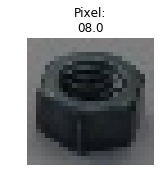

07.2


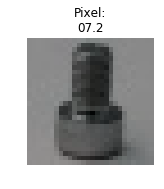

01.0


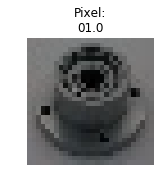

02.0


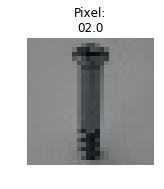

10.0


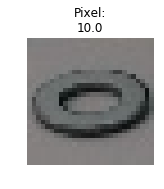

04.0


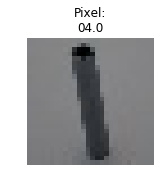

10.0


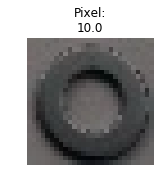

13.0


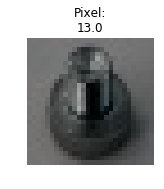

11.0


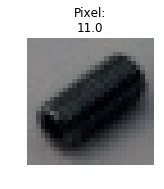

07.1


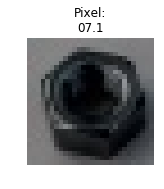

10.0


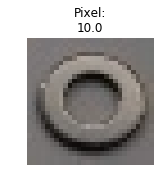

07.2


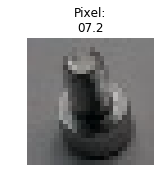

05.0


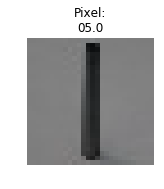

12.0


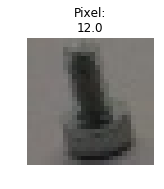

03.0


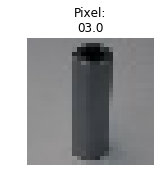

15.0


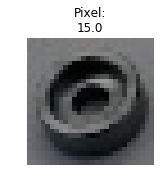

10.0


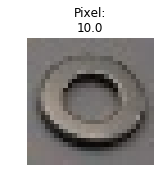

14.0


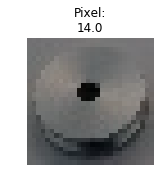

14.0


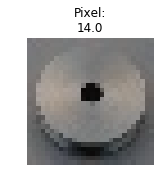

11.0


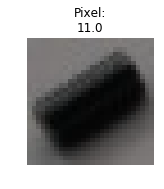

In [10]:
i = 0
while i < 20:
    i =i+1 
    
    X_batch, y_batch, file_name = test_img.get_batch(1)
    label = y_batch
    image_ar = X_batch[0]

    print(label_dict[np.argmax(sess.run(tf.nn.softmax(y_conv, 1), feed_dict={x: X_batch, y_: y_batch, keep_prob: 1}))])




    fig = plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.axis('off')
    ax1.set_title('Pixel:\n' + label_dict[np.argmax(label)])
    ax1.imshow(image_ar, cmap='gray');
    #ax2 = fig.add_subplot(1, 2, 2)
    #ax2.axis('off')
    #ax2.set_title('Gaussian interpolation:\n')
    #ax2.imshow(image_ar, cmap='gray', interpolation="gaussian");
    plt.show()

In [11]:
home = os.getcwd().split('AUT-CNN-TUB')[0]
model_path  = os.path.join(home,'AUT-CNN-TUB', 'Data', 'Models', 'model_canon_{}.ckpt'.format(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")))
saver = tf.train.Saver()
save_path = saver.save(sess, model_path)
print("Model saved in path: %s" % save_path)


Model saved in path: /home/jeronimo/git/AUT-CNN-TUB/Data/Models/model_canon_2018-08-12_15-34.ckpt


In [12]:
sess.close()
